In [42]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

c:\Design_retirement\model.py:67: SyntaxWarning: invalid escape sequence '\o'
  df = pd.read_csv('Data\overlevelses_ssh.csv')


In [55]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

CPU times: total: 2min 47s
Wall time: 25.7 s


In [56]:
# %time model.simulate_prep()
%time model.simulate()

CPU times: total: 12.8 s
Wall time: 11.8 s


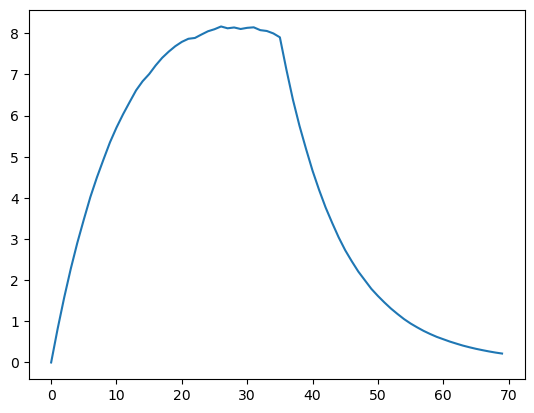

In [57]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


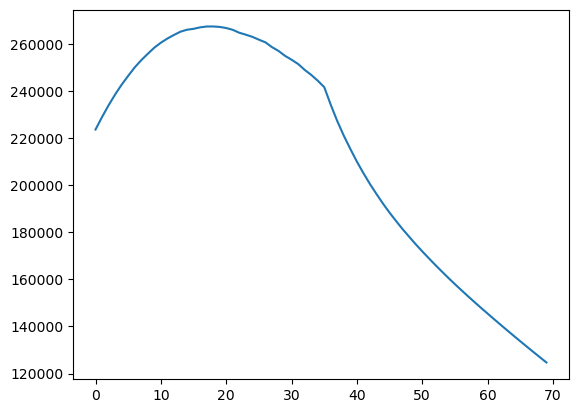

In [58]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


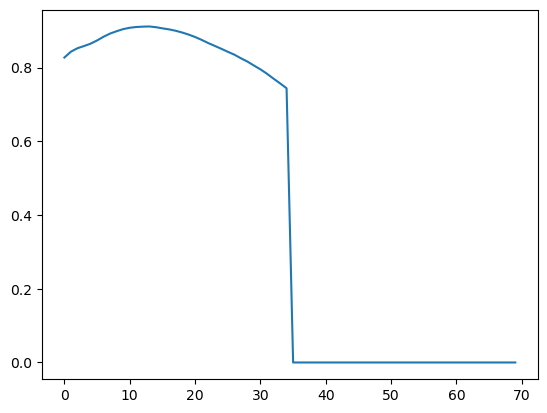

In [59]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


In [60]:
model.sim.a[:]

array([[135000.        , 122789.04597601, 116955.29086996, ...,
        108954.06735799, 107712.63181853, 100557.11596091],
       [135000.        , 122789.04597601, 117698.12652033, ...,
        108263.72067139, 107254.48289238, 100288.58557165],
       [135000.        , 122789.04597601, 117698.12652033, ...,
        108759.56755093, 107583.55192364, 100481.45961328],
       ...,
       [135000.        , 122789.04597601, 117698.12652033, ...,
        108408.31149077, 107350.44066246, 100344.82836931],
       [135000.        , 122789.04597601, 117698.12652033, ...,
        109016.02479186, 107753.74990071, 100581.21610386],
       [135000.        , 122789.04597601, 117309.901431  , ...,
        109425.50516287, 108025.5017551 , 100740.49538418]])

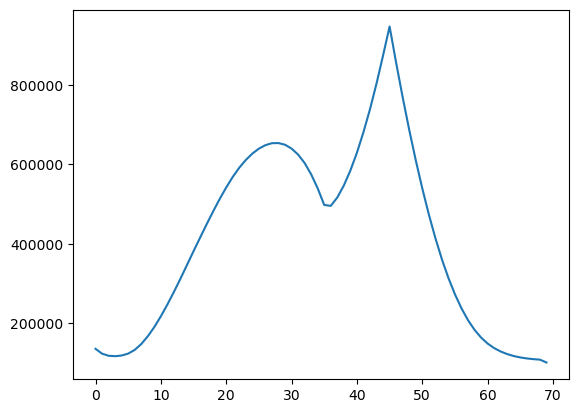

In [61]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))


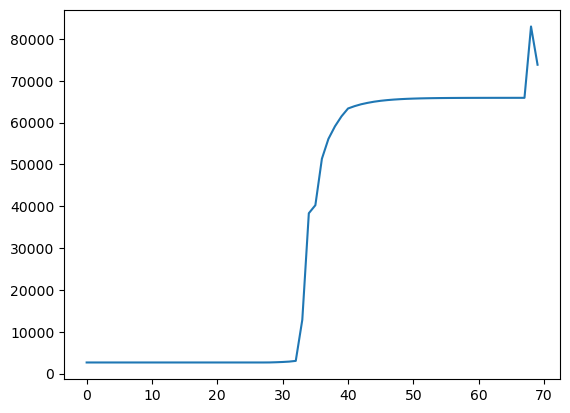

In [28]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


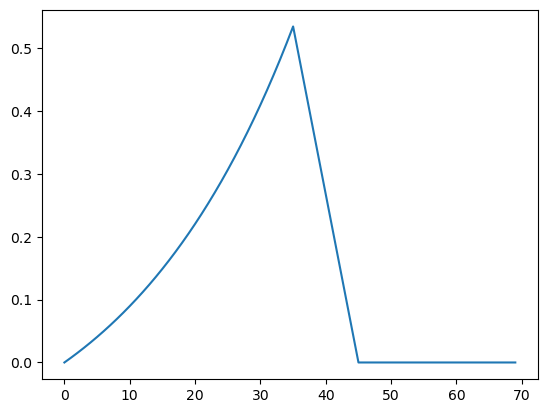

In [29]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


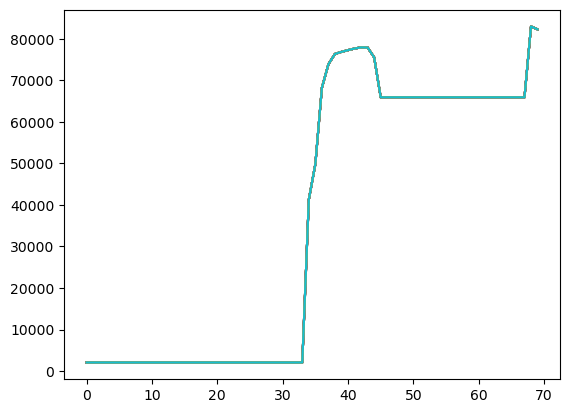

In [30]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [31]:
sol.V

array([[[[-8.10265741e-04, -8.09126326e-04, -8.08020333e-04, ...,
          -7.94917714e-04, -7.94234821e-04, -7.93568942e-04],
         [-8.10265741e-04, -8.09126326e-04, -8.08020333e-04, ...,
          -7.94917714e-04, -7.94234821e-04, -7.93568942e-04],
         [-8.10265741e-04, -8.09126326e-04, -8.08020333e-04, ...,
          -7.94917714e-04, -7.94234821e-04, -7.93568942e-04],
         ...,
         [-8.10265741e-04, -8.09126326e-04, -8.08020333e-04, ...,
          -7.94917714e-04, -7.94234821e-04, -7.93568942e-04],
         [-8.10265741e-04, -8.09126326e-04, -8.08020333e-04, ...,
          -7.94917714e-04, -7.94234821e-04, -7.93568942e-04],
         [-8.10265741e-04, -8.09126326e-04, -8.08020333e-04, ...,
          -7.94917714e-04, -7.94234821e-04, -7.93568942e-04]],

        [[-1.37236256e-06, -1.37236256e-06, -1.37236256e-06, ...,
          -1.37236256e-06, -1.37236256e-06, -1.37236256e-06],
         [-1.37236256e-06, -1.37236256e-06, -1.37236256e-06, ...,
          -1.37236256e

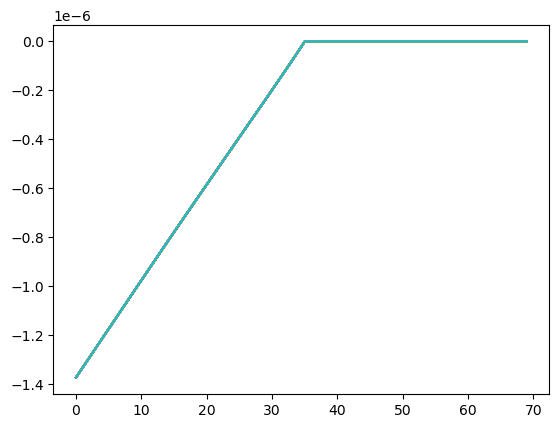

In [32]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 1, 1, i])


In [33]:
sol.V[:, 4, 4, :]

array([[-1.37236256e-06, -1.37236256e-06, -1.37236256e-06, ...,
        -1.37236256e-06, -1.37236256e-06, -1.37236256e-06],
       [-1.33247343e-06, -1.33247343e-06, -1.33247343e-06, ...,
        -1.33247343e-06, -1.33247343e-06, -1.33247343e-06],
       [-1.29286546e-06, -1.29286546e-06, -1.29286546e-06, ...,
        -1.29286546e-06, -1.29286546e-06, -1.29286546e-06],
       ...,
       [-9.36190240e-25, -9.36190240e-25, -9.36190240e-25, ...,
        -9.36190240e-25, -9.36190240e-25, -9.36190240e-25],
       [-2.33983103e-25, -2.33983103e-25, -2.33983103e-25, ...,
        -2.33983103e-25, -2.33983103e-25, -2.33983103e-25],
       [-2.34174743e-25, -2.34174743e-25, -2.34174743e-25, ...,
        -2.34174743e-25, -2.34174743e-25, -2.34174743e-25]])

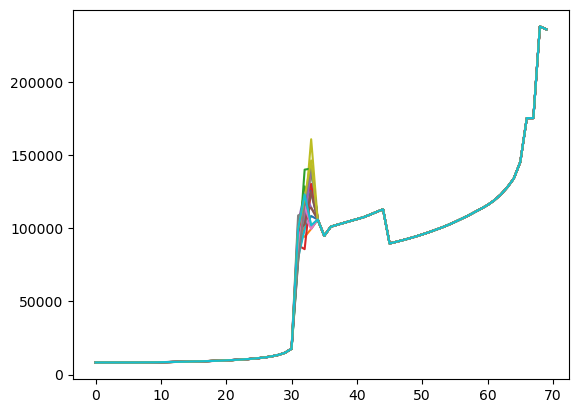

In [34]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [35]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

array([-3.98891280e-08, -3.96079625e-08, -3.97143113e-08, -3.97861514e-08,
       -3.94297304e-08, -3.97300787e-08, -3.98759058e-08, -3.93474293e-08,
       -3.99043744e-08, -3.94773541e-08, -3.94564285e-08, -3.96883143e-08,
       -3.92523356e-08, -3.92525898e-08, -3.92273150e-08, -3.91947524e-08,
       -3.88911492e-08, -3.87453450e-08, -3.87024880e-08, -3.87729341e-08,
       -3.87327015e-08, -3.86871264e-08, -3.87940107e-08, -3.85723388e-08,
       -3.87298272e-08, -3.84529120e-08, -3.85000307e-08, -3.84864130e-08,
       -3.85576132e-08, -3.88379424e-08, -3.89253547e-08, -3.91804692e-08,
       -3.94843595e-08, -3.99631856e-08, -4.05121926e-08, -2.06976791e-23,
       -1.25676533e-23, -1.10380111e-23, -1.04741124e-23, -9.98120851e-24,
       -1.00058672e-23, -7.66948212e-24, -7.61272126e-24, -6.79683056e-24,
        9.13235701e-23, -1.29526495e-23, -1.21469521e-23, -1.14743950e-23,
       -1.08226419e-23, -1.04028031e-23, -9.44732546e-24, -9.08027184e-24,
       -7.93242708e-24, -

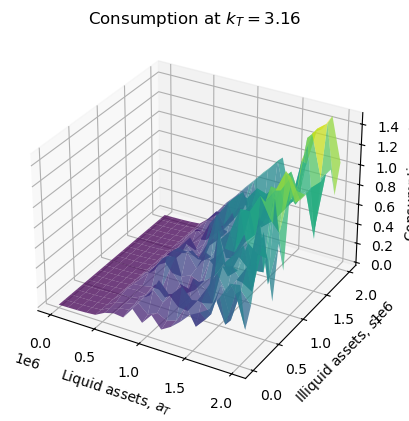

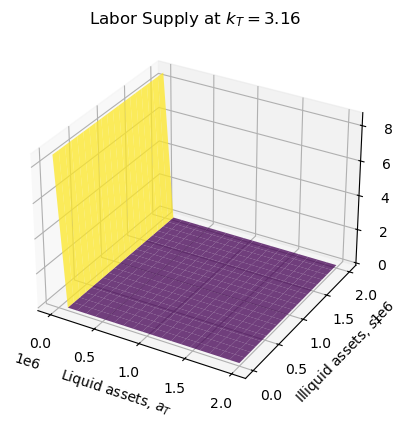

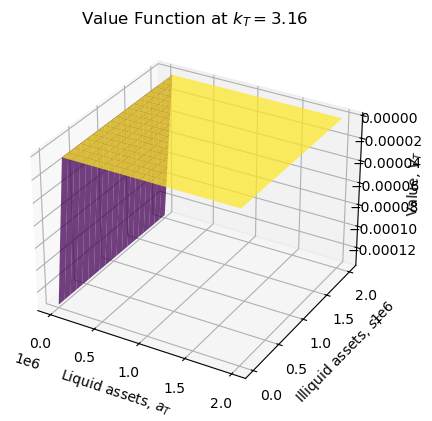

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
